### 1. Data preprocessing

In [1]:
def get_preprocessing(df):
    '''
    Data preprocessing function.
    df - dataframe with at least 2 columns: 
        - date - day of metar string
        - metar - METAR string
    '''
    # clean from RMK - we don't need
    df['metar'] = df['metar'].map(lambda x: x.split(' RMK')[0].strip().replace('SPECI ',''))
    df = df[df.metar.str[:4].isin(['KMIA','SPEC'])].reset_index(drop = True)

    # parsing
    from metar import Metar
    def parse_metar(x):
        try:
            m = Metar.Metar(x.metar, month = x.date.month, year = x.date.year)
        except Exception as e:
            m = Metar.Metar(x.metar[:4], month = x.date.month, year = x.date.year)
        return m
    out = df.apply(parse_metar, axis = 1)
    df_out = pd.DataFrame([x.__dict__ for x in out])

    # choose only useful features
    feats_used = [
        'time',
        'wind_dir',
        'wind_speed',
        'wind_gust',
        'vis',
        'temp',
        'dewpt',
        'press',
        'weather',
        'sky',
    ]
    df_out = df_out[feats_used]

    # time preprocessing
    f1 = df_out.time.isnull()
    df_out = df_out[~f1].sort_values('time').reset_index().set_index('time')
    del df_out['index']
    df_out = df_out.resample('H').last()
    
    ####
    # values convertion
    # get values
    def conv_val(x):
        try:
            return x.value()
        except:
            return np.nan
    
    ####################
    # numerical features
    df_out['wind_dir'] = df_out['wind_dir'].map(conv_val)
    df_out['wind_speed'] = df_out['wind_speed'].map(conv_val)
    df_out['wind_gust'] = df_out['wind_gust'].map(conv_val)
    df_out['vis'] = df_out['vis'].map(conv_val)
    df_out['temp'] = df_out['temp'].map(conv_val)
    df_out['dewpt'] = df_out['dewpt'].map(conv_val)
    df_out['press'] = df_out['press'].map(conv_val)
    
    # corrections
    df_out.loc[df_out['wind_dir'] == 0,   'wind_dir'] = np.nan
    df_out.loc[df_out['wind_speed'] == 0, 'wind_gust'] = np.nan
    
    # fill nulls by the forward fill method
    feats_fill = ['temp','dewpt','press','vis','wind_speed']
    for feat in feats_fill:
        df_out[feat] = df_out[feat].fillna(method = 'ffill')
        
    # add flags that have value
    df_out['vis_unclear_flg'] = (df_out['vis'] < 10).astype(int)
    df_out['wind_speed_flg'] = (df_out['wind_speed'] > 0).astype(int)
    df_out['wind_gust_flg'] = (df_out['wind_gust'].notnull()).astype(int)
    df_out['wind_dir_flg'] = (df_out['wind_dir'].notnull()).astype(int)
    
    # fill nulls again
    df_out['wind_dir'] = df_out['wind_dir'].fillna(method = 'ffill')
    df_out['wind_gust'] = df_out['wind_gust'].fillna(method = 'ffill')
    
        
    #######################
    # categorical features
    df_out['id1'] = range(len(df_out))
    def conv_list(df, feat):
        '''
        # unflat lists
        '''
        out1 = list()
        out2 = list()
        for _, r in df.iterrows():
            out1+=r[feat]
            out2+=[r.id1]*len(r[feat])
        df1 = pd.DataFrame(out1)
        df1['id1'] = out2
        return df1

    
    # weather
    df1 = df_out[~df_out['weather'].isnull()]
    df1 = df1[df1['weather'].map(len) > 0][['weather','id1']]
    df2 = conv_list(df1, 'weather')
    
    df2['weather_rain'] = 0
    df2.loc[(df2[0] == '-') & (df2[2].isin(['RA','DZ'])), 'weather_rain'] = 1
    df2.loc[(df2[0] == '')  & (df2[2].isin(['RA','DZ'])), 'weather_rain'] = 2
    df2.loc[(df2[0] == '+') & (df2[2].isin(['RA','DZ'])), 'weather_rain'] = 3
    df2['weather_rain_flg'] = (df2['weather_rain'] > 0).astype(int)

    df2['weather_ts'] = 0
    df2.loc[(df2[1] == 'TS'), 'weather_ts'] = 1

    df2['weather_fog'] = 0
    df2.loc[(df2[3].isin(['BR'])), 'weather_fog'] = 1
    df2.loc[(df2[3].isin(['HZ'])), 'weather_fog'] = 2
    df2.loc[(df2[3].isin(['FG'])), 'weather_fog'] = 3
    df2.loc[(df2[3].isin(['FU'])), 'weather_fog'] = 4
    df2['weather_fog_flg'] = (df2['weather_fog'] > 0).astype(int)
    
    feats1 = ['weather_rain', 'weather_rain_flg', 'weather_ts', 'weather_fog', 'weather_fog_flg']
    df3 = df2.groupby('id1')[feats1].max().reset_index()
    ind = df_out.index
    df_out = df_out.merge(df3[['id1'] + feats1], how = 'left', on = 'id1')
    df_out.index = ind
    for f in feats1:
        df_out[f] = df_out[f].fillna(0)
    
    del df1
    del df2
    gc.collect()
    
    # sky
    df1 = df_out[~df_out['sky'].isnull()]
    df1 = df1[df1['sky'].map(len) > 0][['sky','id1']]
    df2 = conv_list(df1, 'sky')
    
    df2[1] = df2[1].map(conv_val).fillna(0)
    df2[2] = df2[2].fillna('')
    
    df21 = pd.concat([
        df2[['id1',0,1]].rename(columns = {0:'var'}), 
        df2[['id1',2,1]].rename(columns = {2:'var'}) ])
    sky_used = ['BKN','FEW','SCT','OVC','CLR','CB','TCU']
    filt = df21['var'].isin(sky_used)
    
    df3 = df21[filt].groupby(['id1','var']).size().unstack().fillna(0)
    cols = df3.columns
    pre = 'sky_cnt_'
    df3.columns = [pre+c for c in cols]
    ind = df_out.index
    df_out = df_out.merge(df3.reset_index(), how = 'left')
    df_out.index = ind
    for f in sky_used:
        df_out[pre+f] = df_out[pre+f].fillna(0)
        df_out['sky_flg_'+f] = (df_out[pre+f] > 0).astype(int)

    df3 = df21[filt].groupby(['id1','var'])[1].mean().unstack().fillna(0)
    cols = df3.columns
    pre = 'sky_avg_'
    df3.columns = [pre+c for c in cols]
    ind = df_out.index
    df_out = df_out.merge(df3.reset_index(), how = 'left')
    df_out.index = ind
    for f in sky_used:
        df_out[pre+f] = df_out[pre+f].fillna(0)
        
    del df1
    del df2
    del df21
    del df3
    gc.collect()
    
    del df_out['sky']
    del df_out['weather']
    del df_out['id1']
    
    return df_out

In [2]:
# read data
df = pd.read_csv('data/METAR_2014_2023.csv')
df['date'] = pd.to_datetime(df['date'])
print(df.shape)
df[:3]

(89590, 3)


,airport_id,date,metar
0,KMIA,2014-01-01,KMIA 010053Z 04009G15KT 10SM OVC025 23/18 A302...
1,KMIA,2014-01-01,KMIA 010153Z 04009G15KT 10SM OVC023 23/18 A302...
2,KMIA,2014-01-01,KMIA 010253Z 05009G19KT 10SM -RA OVC025 23/18 ...


In [3]:
# preprocessing
df = get_preprocessing(df)
df.to_pickle('data/df.pkl')
print(df.shape)
df[:3]

(87648, 37)


,wind_dir,wind_speed,wind_gust,vis,temp,dewpt,press,vis_unclear_flg,wind_speed_flg,wind_gust_flg,wind_dir_flg,weather_rain,weather_rain_flg,weather_ts,weather_fog,weather_fog_flg,sky_cnt_BKN,sky_cnt_CB,sky_cnt_CLR,sky_cnt_FEW,sky_cnt_OVC,sky_cnt_SCT,sky_cnt_TCU,sky_flg_BKN,sky_flg_FEW,sky_flg_SCT,sky_flg_OVC,sky_flg_CLR,sky_flg_CB,sky_flg_TCU,sky_avg_BKN,sky_avg_CB,sky_avg_CLR,sky_avg_FEW,sky_avg_OVC,sky_avg_SCT,sky_avg_TCU
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,40.00,9.00,15.00,10.00,23.00,18.00,30.21,0,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,1,0,0,0,0.00,0.00,0.00,0.00,"2,500.00",0.00,0.00
2014-01-01 01:00:00,40.00,9.00,15.00,10.00,23.00,18.00,30.21,0,1,1,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,1,0,0,0,0.00,0.00,0.00,0.00,"2,300.00",0.00,0.00
2014-01-01 02:00:00,50.00,9.00,19.00,10.00,23.00,18.00,30.23,0,1,1,1,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,1,0,0,0,0.00,0.00,0.00,0.00,"2,500.00",0.00,0.00


Text(0.5, 1.0, 'Correlation matrix')

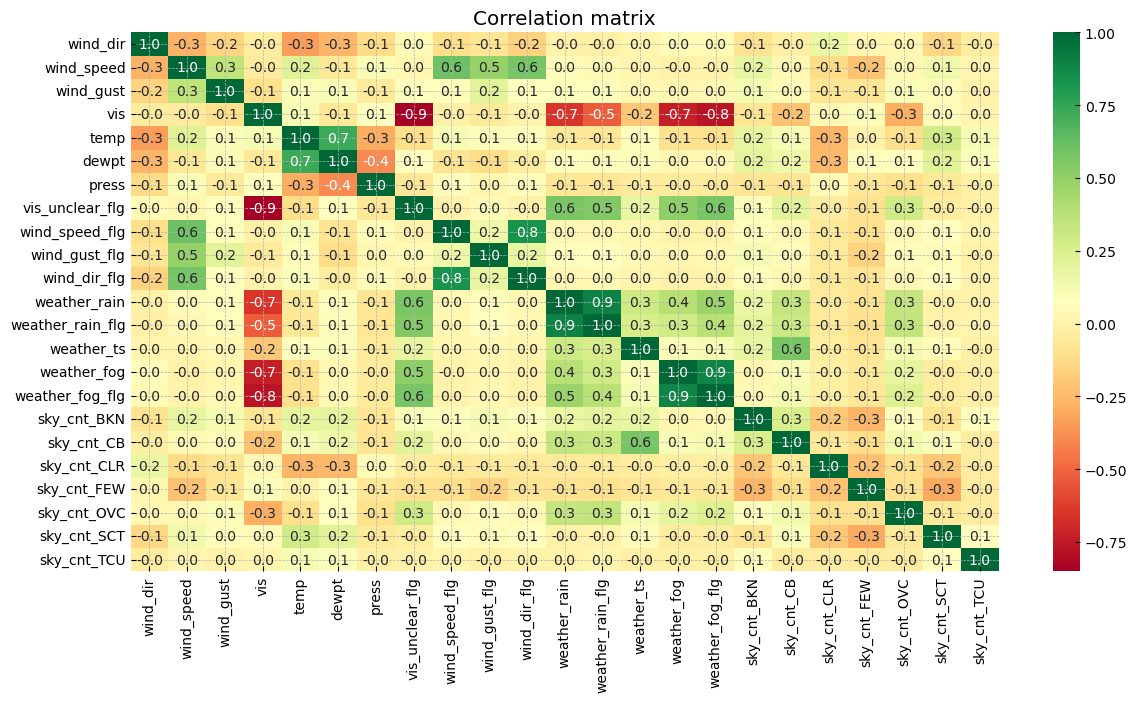

In [14]:
# correlations
df_corr = df.iloc[:,:-14].corr()
_, ax = plt.subplots(figsize = (14,7))
_ = sns.heatmap(df_corr, ax = ax, cmap = 'RdYlGn', annot = True, fmt = '.1f', annot_kws={"size": 10})
_.set_title('Correlation matrix')

In [5]:
# list(df.columns)

In [6]:
df.isnull().sum().sum()

0

In [19]:
# print('\n'.join(df.columns))

### 2. Feature engineering

In [7]:
from window_ops.rolling import rolling_mean, rolling_max, rolling_min, seasonal_rolling_mean
from numba import njit

import mlforecast
from mlforecast import MLForecast
from mlforecast import target_transforms

In [8]:
def get_features(df):
    '''
    Feature engineering function.
    '''
    df = df.reset_index()
    df['unique_id'] = 'a'

    # feature engine
    model = MLForecast(
        models = {},
        freq = 'H',
        target_transforms = [
        ],
        lags = [1] + [24],
        lag_transforms = {
            1:  [
                (rolling_mean, 3),
                (seasonal_rolling_mean, 24, 3), 
            ],
        },
        # date_features=['month','hour'],
    )
    # main feats
    df_all = df[['time']]
    feats_target = list(df.columns)[1:-1]
    for feat in feats_target:
        feats0 = ['unique_id','time',feat]
        df1 = model.preprocess(df[feats0], id_col = 'unique_id', time_col = 'time', target_col = feat)
        del df1['unique_id']
        cols = [f'{feat}_'+c.replace('rolling_mean','RM').replace('window_size','WS').replace('seasonal','S').replace('season_length','SL') for c in list(df1.columns)[2:]]
        df1.columns = list(df1.columns)[:2] + cols

        eps = 1e-12
        df1[f'{feat}_lag1to3'] = df1[f'{feat}_lag1'] / (df1[f'{feat}_RM_lag1_WS3'] + eps)
        df1[f'{feat}_lag24to72'] = df1[f'{feat}_lag24'] / (df1[f'{feat}_S_RM_lag1_SL24_WS3'] + eps)

        df_all = df_all.merge(df1, on = 'time', how = 'left')
        
    # date feats
    df_all['dt_month'] = df_all['time'].dt.month
    df_all['dt_hour'] = df_all['time'].dt.hour
    
    # return df_all
    return df_all[df_all.wind_dir.notnull()]

In [9]:
# features
df_all = get_features(df)
df_all.to_pickle('data/df_feats.pkl')
print(df_all.shape)
df_all[:5]

(87599, 262)


,time,wind_dir,wind_dir_lag1,wind_dir_lag24,wind_dir_RM_lag1_WS3,wind_dir_S_RM_lag1_SL24_WS3,wind_dir_lag1to3,wind_dir_lag24to72,wind_speed,wind_speed_lag1,wind_speed_lag24,wind_speed_RM_lag1_WS3,wind_speed_S_RM_lag1_SL24_WS3,wind_speed_lag1to3,wind_speed_lag24to72,wind_gust,wind_gust_lag1,wind_gust_lag24,wind_gust_RM_lag1_WS3,wind_gust_S_RM_lag1_SL24_WS3,wind_gust_lag1to3,wind_gust_lag24to72,vis,vis_lag1,vis_lag24,vis_RM_lag1_WS3,vis_S_RM_lag1_SL24_WS3,vis_lag1to3,vis_lag24to72,temp,temp_lag1,temp_lag24,temp_RM_lag1_WS3,temp_S_RM_lag1_SL24_WS3,temp_lag1to3,temp_lag24to72,dewpt,dewpt_lag1,dewpt_lag24,dewpt_RM_lag1_WS3,dewpt_S_RM_lag1_SL24_WS3,dewpt_lag1to3,dewpt_lag24to72,press,press_lag1,press_lag24,press_RM_lag1_WS3,press_S_RM_lag1_SL24_WS3,press_lag1to3,press_lag24to72,vis_unclear_flg,vis_unclear_flg_lag1,vis_unclear_flg_lag24,vis_unclear_flg_RM_lag1_WS3,vis_unclear_flg_S_RM_lag1_SL24_WS3,vis_unclear_flg_lag1to3,vis_unclear_flg_lag24to72,wind_speed_flg,wind_speed_flg_lag1,wind_speed_flg_lag24,wind_speed_flg_RM_lag1_WS3,wind_speed_flg_S_RM_lag1_SL24_WS3,wind_speed_flg_lag1to3,wind_speed_flg_lag24to72,wind_gust_flg,wind_gust_flg_lag1,wind_gust_flg_lag24,wind_gust_flg_RM_lag1_WS3,wind_gust_flg_S_RM_lag1_SL24_WS3,wind_gust_flg_lag1to3,wind_gust_flg_lag24to72,wind_dir_flg,wind_dir_flg_lag1,wind_dir_flg_lag24,wind_dir_flg_RM_lag1_WS3,...,sky_flg_OVC_S_RM_lag1_SL24_WS3,sky_flg_OVC_lag1to3,sky_flg_OVC_lag24to72,sky_flg_CLR,sky_flg_CLR_lag1,sky_flg_CLR_lag24,sky_flg_CLR_RM_lag1_WS3,sky_flg_CLR_S_RM_lag1_SL24_WS3,sky_flg_CLR_lag1to3,sky_flg_CLR_lag24to72,sky_flg_CB,sky_flg_CB_lag1,sky_flg_CB_lag24,sky_flg_CB_RM_lag1_WS3,sky_flg_CB_S_RM_lag1_SL24_WS3,sky_flg_CB_lag1to3,sky_flg_CB_lag24to72,sky_flg_TCU,sky_flg_TCU_lag1,sky_flg_TCU_lag24,sky_flg_TCU_RM_lag1_WS3,sky_flg_TCU_S_RM_lag1_SL24_WS3,sky_flg_TCU_lag1to3,sky_flg_TCU_lag24to72,sky_avg_BKN,sky_avg_BKN_lag1,sky_avg_BKN_lag24,sky_avg_BKN_RM_lag1_WS3,sky_avg_BKN_S_RM_lag1_SL24_WS3,sky_avg_BKN_lag1to3,sky_avg_BKN_lag24to72,sky_avg_CB,sky_avg_CB_lag1,sky_avg_CB_lag24,sky_avg_CB_RM_lag1_WS3,sky_avg_CB_S_RM_lag1_SL24_WS3,sky_avg_CB_lag1to3,sky_avg_CB_lag24to72,sky_avg_CLR,sky_avg_CLR_lag1,sky_avg_CLR_lag24,sky_avg_CLR_RM_lag1_WS3,sky_avg_CLR_S_RM_lag1_SL24_WS3,sky_avg_CLR_lag1to3,sky_avg_CLR_lag24to72,sky_avg_FEW,sky_avg_FEW_lag1,sky_avg_FEW_lag24,sky_avg_FEW_RM_lag1_WS3,sky_avg_FEW_S_RM_lag1_SL24_WS3,sky_avg_FEW_lag1to3,sky_avg_FEW_lag24to72,sky_avg_OVC,sky_avg_OVC_lag1,sky_avg_OVC_lag24,sky_avg_OVC_RM_lag1_WS3,sky_avg_OVC_S_RM_lag1_SL24_WS3,sky_avg_OVC_lag1to3,sky_avg_OVC_lag24to72,sky_avg_SCT,sky_avg_SCT_lag1,sky_avg_SCT_lag24,sky_avg_SCT_RM_lag1_WS3,sky_avg_SCT_S_RM_lag1_SL24_WS3,sky_avg_SCT_lag1to3,sky_avg_SCT_lag24to72,sky_avg_TCU,sky_avg_TCU_lag1,sky_avg_TCU_lag24,sky_avg_TCU_RM_lag1_WS3,sky_avg_TCU_S_RM_lag1_SL24_WS3,sky_avg_TCU_lag1to3,sky_avg_TCU_lag24to72,dt_month,dt_hour
49,2014-01-03 01:00:00,230.00,230.00,110.00,230.00,126.67,1.00,0.87,5.00,5.00,6.00,5.67,6.67,0.88,0.90,18.00,18.00,18.00,18.00,17.00,1.00,1.06,10.00,10.00,10.00,10.00,10.00,1.00,1.00,23.00,24.00,24.00,25.00,23.67,0.96,1.01,20.00,19.00,22.00,19.00,19.67,1.00,1.12,29.96,29.95,30.09,29.94,30.08,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.33,0.00,0.00,1.00,1.00,1.00,1.00,...,0.33,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"3,000.00","3,000.00","1,200.00","3,033.33","1,500.00",0.99,0.80,0.00,0.00,0.00,0.00,833.33,0.00,0.00,0.00,0.00,0.00,0.00,"8,333.33",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,1
50,2014-01-03 02:00:00,220.00,230.00,120.00,233.33,126.67,0.99,0.95,4.00,5.00,6.00,5.00,6.67,1.00,0.90,18.00,18.00,18.00,18.00,17.00,1.00,1.06,10.00,10.00,10.00,10.00,10.00,1.00,1.00,23.00,23.00,24.00,24.00,23.33,0.96,1.03,21.00,20.00,22.00,19.33,20.00,1.03,1.10,29.96,29.96,30.09,29.95,3

In [10]:
df_all.isnull().sum().sum()

0